In [1]:
# this time if there is a high threshold or cv will choose max instead of median

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import csv
import pickle
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2, venn2_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
# build the final data frame

# loading the dataset which has the features (gene symbol)
file_path = 'dataset/ADNI_Gene_Expression_Profile.csv'
df1 = pd.read_csv(file_path)

# df1.head()

col = df1.columns[3:747]
# print(len(c))
sampleList = []
for c in col:
    sample = df1.loc[:, c]
    sample = sample.tolist()
    sampleList.append(sample)
    
file_path = 'dataset/Complete_ADNI_clinical_info.csv'
df2 = pd.read_csv(file_path)

# df2.head(10)

tem_col = list(df1['Unnamed: 2'])
tem_col[1] = 'IID'

finalDataFrame = pd.DataFrame(sampleList, columns=tem_col)
finalDataFrame = finalDataFrame.loc[:, finalDataFrame.columns.notna()]
finalDataFrame = finalDataFrame.drop(columns=['Symbol'])

finalDataFrame['Age'] = ""
finalDataFrame['Gender'] = ""
finalDataFrame['Ethnicity'] = ""
finalDataFrame['Race'] = ""
finalDataFrame['Phenotype'] = ""

for index, row in finalDataFrame.iterrows():
    patientID = finalDataFrame.at[index, 'IID']
    # cell_value = df.at[row_number, column_name]
    #print("P ID: ", patient)
    for index2, row2 in df2.iterrows():
        if df2.at[index2, 'IID'] == patientID:
            finalDataFrame.at[index, 'Age'] = df2.at[index2, 'Age']
            finalDataFrame.at[index, 'Gender'] = df2.at[index2, 'Gender']
            finalDataFrame.at[index, 'Ethnicity'] = df2.at[index2, 'Ethnicity']
            finalDataFrame.at[index, 'Race'] = df2.at[index2, 'Race']
            finalDataFrame.at[index, 'Phenotype'] = df2.at[index2, 'Phenotype']

In [5]:
pickle_file_name = 'keyDictionaryPickel.pickle'
with open(pickle_file_name, 'rb') as file:
    keyDictionary = pickle.load(file)

In [6]:
geneMetrics = pd.read_csv("dataset/Gene_Metrics_Info.csv")

In [7]:
# geneMetrics.head()

In [8]:
lowHighGeneSymbolBasedOnStd = {}

for index, row in geneMetrics.iterrows():
    msd = geneMetrics.at[index, 'Mean Standard Deviation']
    key = geneMetrics.at[index, 'Gene Symbol']
    if msd > 1.5:
        lowHighGeneSymbolBasedOnStd[key] = 1
    else:
        lowHighGeneSymbolBasedOnStd[key] = 0

In [9]:
columns =  set(finalDataFrame.columns)
idxs = finalDataFrame["IID"]

In [10]:
dic = defaultdict(list)
for idx in idxs:
    for col in columns:
        res = keyDictionary.get((idx, col))
        if res:
            if lowHighGeneSymbolBasedOnStd[col] == 0:
                dic[col].append(np.mean(res))
            else:
                dic[col].append(np.amax(res))
lastBasedOnStd = pd.DataFrame(dic)

In [11]:
original_col = finalDataFrame.columns
new_colBasedOnStd = lastBasedOnStd.columns
disjointBasedOnStd = [i for i in original_col if i not in new_colBasedOnStd]
lastBasedOnStd = lastBasedOnStd.merge(finalDataFrame[disjointBasedOnStd], left_index=True, right_index=True)

In [12]:
lastBasedOnStd.replace("", np.nan, inplace=True)
print(sum(lastBasedOnStd.isna().sum()))
lastBasedOnStd = lastBasedOnStd[lastBasedOnStd["Phenotype"].notna()].reset_index(drop=True)
print(sum(lastBasedOnStd.isna().sum()))

80
0


In [13]:
for col in lastBasedOnStd.columns:
    if (
        any(lastBasedOnStd[col].isna())
        and lastBasedOnStd[col].isna().value_counts().to_dict().get(True) / len(lastBasedOnStd[col])
        > 0.90
    ):
        print(col)
        lastBasedOnStd = lastBasedOnStd.drop(col, axis=1)

In [14]:
featuresBasedOnStd = lastBasedOnStd.drop('Phenotype', axis = 1)
targetBasedOnStd = lastBasedOnStd['Phenotype']
featuresBasedOnStd = featuresBasedOnStd.drop('IID', axis = 1)

In [15]:
lasso1 = Lasso(alpha=0.01)
lasso1.fit(featuresBasedOnStd, targetBasedOnStd)
selectedFeaturesBasedOnStd = featuresBasedOnStd.columns[lasso1.coef_ != 0.0]

In [16]:
len(selectedFeaturesBasedOnStd)

321

In [17]:
X = lastBasedOnStd[selectedFeaturesBasedOnStd]
y = lastBasedOnStd['Phenotype']

In [18]:
X.head()

,KANK1,HSD17B13,SRD5A3,LINC00494,PPAT,SPRY1,PFN1P2,MEX3C,TWSG1,GOLGA8A,...,CATR1,LOC101927618,ENSG00000211776,ENSG00000211716 || ENSG00000261031,ENSG00000211638,IGHA2,LOC100505946,LOC101929125,SNORA16B,Age
0,6.824,5.761,5.484,4.689,9.027,3.713667,4.062667,7.854,3.961333,8.144,...,3.110,4.705,4.460,7.021,4.070,8.176,2.307,5.371,3.551,78.8
1,6.741,4.769,6.415,5.149,8.697,3.043333,5.147333,8.909,5.278667,7.863,...,2.953,4.929,4.955,6.793,4.352,8.014,2.488,6.921,3.507,69.1
2,5.880,4.733,4.901,7.249,9.405,3.047667,5.435333,7.635,3.341667,7.608,...,3.068,4.678,5.399,7.118,6.438,8.827,2.548,5.891,3.916,79.3
3,6.968,5.653,5.450,6.449,9.091,2.155667,4.993333,6.115,4.006333,7.368,...,2.899,4.900,5.327,7.296,4.446,8.453,2.821,5.908,3.627,72.1
4,7.305,5.173,5.598,4.663,9.517,3.026000,4.670667,8.149,3.815667,8.080,...,3.493,5.502,5.383,6.736,3.093,9.516,2.436,5.862,3.383,86.4


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
y_train = y_train.values
y_test = y_test.values

In [22]:
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

In [23]:
parameterGrid = { 
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}

In [24]:
gridSearch = GridSearchCV(RandomForestClassifier(), 
                           param_grid=parameterGrid) 
gridSearch.fit(X_train, y_train) 
print(gridSearch.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=200)


In [25]:
model = RandomForestClassifier(n_estimators=200, max_depth=9, max_features=None, max_leaf_nodes=9, random_state=42)

In [26]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=200, random_state=42)

In [27]:
y_pred = model.predict(X_test)

In [28]:
accuracy = accuracy_score(y_test, y_pred)

In [29]:
print(accuracy)

0.4726027397260274


In [30]:
cm = confusion_matrix(y_test, y_pred)

In [31]:
cmDF = pd.DataFrame(cm,
                     index = ['Control','MCI','AD'], 
                     columns = ['Control','MCI','AD'])

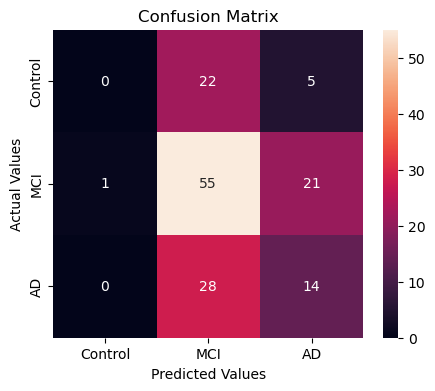

In [32]:
# plotting the confusion matrix to represent the preformance of Random Forest Model
plt.figure(figsize=(5,4))
sns.heatmap(cmDF, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [33]:
lowHighGeneSymbolBasedOnCV = {}

for index, row in geneMetrics.iterrows():
    mcv = geneMetrics.at[index, 'Mean CV']
    key = geneMetrics.at[index, 'Gene Symbol']
    if mcv > 0.35:
        lowHighGeneSymbolBasedOnCV[key] = 1
    else:
        lowHighGeneSymbolBasedOnCV[key] = 1

In [34]:
columns =  set(finalDataFrame.columns)
idxs = finalDataFrame["IID"]

In [35]:
dic = defaultdict(list)
for idx in idxs:
    for col in columns:
        res = keyDictionary.get((idx, col))
        if res:
            if lowHighGeneSymbolBasedOnCV[col] == 0:
                dic[col].append(np.mean(res))
            else:
                dic[col].append(np.amax(res))
lastBasedOnCV = pd.DataFrame(dic)

In [36]:
original_col = finalDataFrame.columns
new_colBasedOnCV = lastBasedOnCV.columns
disjointBasedOnCV = [i for i in original_col if i not in new_colBasedOnCV]
lastBasedOnCV = lastBasedOnCV.merge(finalDataFrame[disjointBasedOnCV], left_index=True, right_index=True)

In [37]:
lastBasedOnCV.replace("", np.nan, inplace=True)
print(sum(lastBasedOnCV.isna().sum()))
lastBasedOnCV = lastBasedOnCV[lastBasedOnCV["Phenotype"].notna()].reset_index(drop=True)
print(sum(lastBasedOnCV.isna().sum()))

80
0


In [38]:
for col in lastBasedOnCV.columns:
    if (
        any(lastBasedOnCV[col].isna())
        and lastBasedOnCV[col].isna().value_counts().to_dict().get(True) / len(lastBasedOnCV[col])
        > 0.90
    ):
        print(col)
        lastBasedOnCV = lastBasedOnCV.drop(col, axis=1)

In [39]:
featuresBasedOnCV = lastBasedOnCV.drop('Phenotype', axis = 1)
targetBasedOnCV = lastBasedOnCV['Phenotype']
featuresBasedOnCV = featuresBasedOnCV.drop('IID', axis = 1)

In [40]:
lasso2 = Lasso(alpha=0.01)
lasso2.fit(featuresBasedOnCV, targetBasedOnCV)
selectedFeaturesBasedOnCV = featuresBasedOnCV.columns[lasso2.coef_ != 0.0]

In [41]:
len(selectedFeaturesBasedOnCV)

364

In [42]:
X2 = lastBasedOnCV[selectedFeaturesBasedOnCV]
y2 = lastBasedOnCV['Phenotype']

In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [44]:
scaler2 = StandardScaler()
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)

In [45]:
y_train2 = y_train2.values
y_test2 = y_test2.values

In [46]:
y_train2 = y_train2.astype(np.int)
y_test2 = y_test2.astype(np.int)

In [47]:
model2 = RandomForestClassifier(n_estimators=200, max_depth=9, max_features=None, max_leaf_nodes=9, random_state=42)

In [48]:
model2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=200, random_state=42)

In [49]:
y_pred2 = model2.predict(X_test2)

In [50]:
accuracy2 = accuracy_score(y_test2, y_pred2)

In [51]:
print(accuracy2)

0.5136986301369864


In [52]:
cm2 = confusion_matrix(y_test2, y_pred2)

In [53]:
cmDF2 = pd.DataFrame(cm2,
                     index = ['Control','MCI','AD'], 
                     columns = ['Control','MCI','AD'])

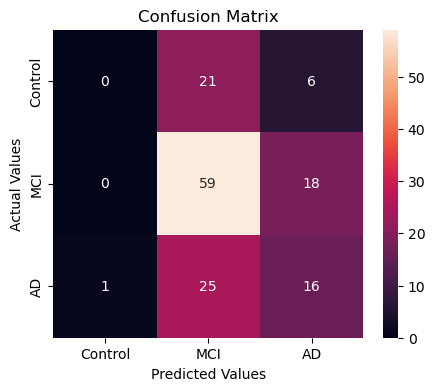

In [54]:
# plotting the confusion matrix to represent the preformance of Random Forest Model
plt.figure(figsize=(5,4))
sns.heatmap(cmDF2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [55]:
selectedFeaturesBasedOnStdList = selectedFeaturesBasedOnStd.tolist()
selectedFeaturesBasedOnCVList = selectedFeaturesBasedOnCV.tolist()

In [56]:
print(len(selectedFeaturesBasedOnStdList))
print(len(selectedFeaturesBasedOnCVList))

321
364


In [57]:
inBothList = 0

for feature in selectedFeaturesBasedOnStdList:
    if feature in selectedFeaturesBasedOnCVList:
        inBothList += 1
        
onlyInFirstList = len(selectedFeaturesBasedOnStdList) - inBothList
onlyInSecondList = len(selectedFeaturesBasedOnCVList) - inBothList

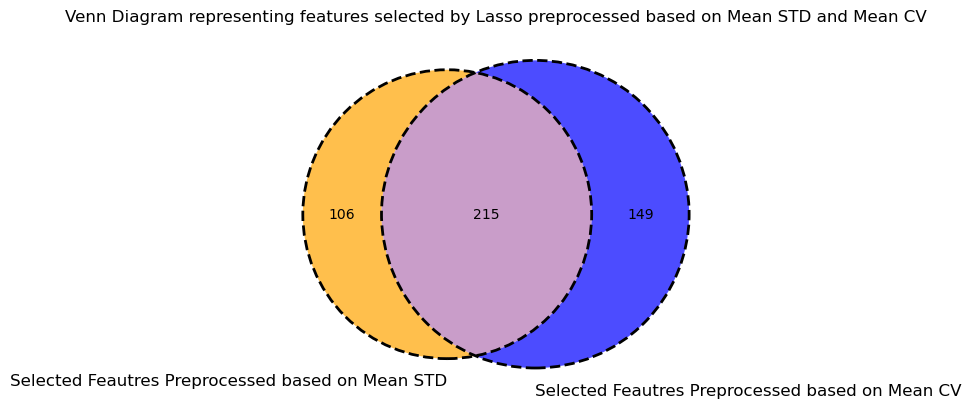

In [58]:
# depict venn diagram 
venn2(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
      set_labels=('Selected Feautres Preprocessed based on Mean STD', 'Selected Feautres Preprocessed based on Mean CV'), 
      set_colors=("orange", "blue"), alpha=.7) 
  
# add outline 
venn2_circles(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
              linestyle="dashed",  
              linewidth=2) 
  

# assign title of the venn diagram 
plt.title("Venn Diagram representing features selected by Lasso preprocessed based on Mean STD and Mean CV")   
plt.show()

In [ ]:
import csv

In [ ]:
csv_file = "selectedFeaturesBasedOnStdListMedian.csv"

In [ ]:
with open(csv_file, 'w', newline='') as file:
    # Create a CSV writer
    writer = csv.writer(file)
    
    # Write the strings to the CSV file
    for feature in selectedFeaturesBasedOnStdList:
        writer.writerow([feature])

In [ ]:
for feature in selectedFeaturesBasedOnStdList:
    print(feature)

In [ ]:
for feature in selectedFeaturesBasedOnCVList:
    print(feature)